# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


Populating the interactive namespace from numpy and matplotlib


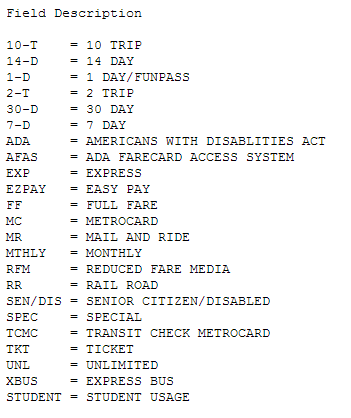

In [1]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

# Read in data

In [2]:
mta = np.load('MTA_Fare.npy')

In [3]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


Create a "ride types" list based on the metadata

In [4]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("Number of ride types", len(ridetype))

Number of ride types 23


Create a date range

In [5]:
#Create date range (adjusted to have the 194 weeks in between the dates given)
date_range = pd.date_range(start='05/24/2010', end='02/14/2014', freq='W')
len(date_range)
date_range

DatetimeIndex(['2010-05-30', '2010-06-06', '2010-06-13', '2010-06-20',
               '2010-06-27', '2010-07-04', '2010-07-11', '2010-07-18',
               '2010-07-25', '2010-08-01',
               ...
               '2013-12-08', '2013-12-15', '2013-12-22', '2013-12-29',
               '2014-01-05', '2014-01-12', '2014-01-19', '2014-01-26',
               '2014-02-02', '2014-02-09'],
              dtype='datetime64[ns]', length=194, freq='W-SUN')

Transform -1 to NaN

In [6]:
#How many -1
len(mta[mta==-1])

649563

In [7]:
#Set -1 as nan. Need to change array to float first
mta = mta.astype(float)
mta[mta==-1] = np.nan
mta.shape

(600, 23, 194)

In [8]:
len(mta[mta==-1])

0

In [9]:
len(mta[np.isnan(mta)])

649563

Plot the data

In [ ]:
#Plot
fig, (ax1, ax2) = pl.subplots(2,1, figsize=(20,14))
fig.subplots_adjust(hspace=0.3)

#Natural space
for i in range(0,mta.shape[0]):
    for j in range (0, mta.shape[1]):
        ax1.plot(date_range, mta[i][j], '-')

ax1.set_title('Weekly rides for each station and each ride type')
ax1.set_xlabel('week')
ax1.set_ylabel('swipes')

#Log space
for i in range(0,mta.shape[0]):
    for j in range (0, mta.shape[1]):
        ax2.plot(date_range, np.log10(mta[i][j]), '-')

ax2.set_title('Weekly rides for each station and each ride type in semi-log space')
ax2.set_xlabel('week')
ax2.set_ylabel('swipes (log10)')

pl.show()

**Figure 1: Weekly time series for all ride types and all stations.** The plot on the has the actual count of swipes for each week, while the one in the bottom is in log space.

# 1: Event detection 

## Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 



In [10]:
#Get the total rides for each week (sum across stations and ride types)
mta_total_week = np.nansum(np.nansum(mta, axis=0), axis=0)

In [11]:
#Calculate the threshold
print ("mean swipes by day {:.2f}".format(mta_total_week.mean()))
print ("stdev swipes by day {:.2f}".format(mta_total_week.std()))
thresholds = [mta_total_week.mean() + 3 * mta_total_week.std(), 
              mta_total_week.mean() - 3 * mta_total_week.std()]
print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))

mean swipes by day 29781349.87
stdev swipes by day 2983960.42
3-sigma thresholds 38733231.14 20829468.61


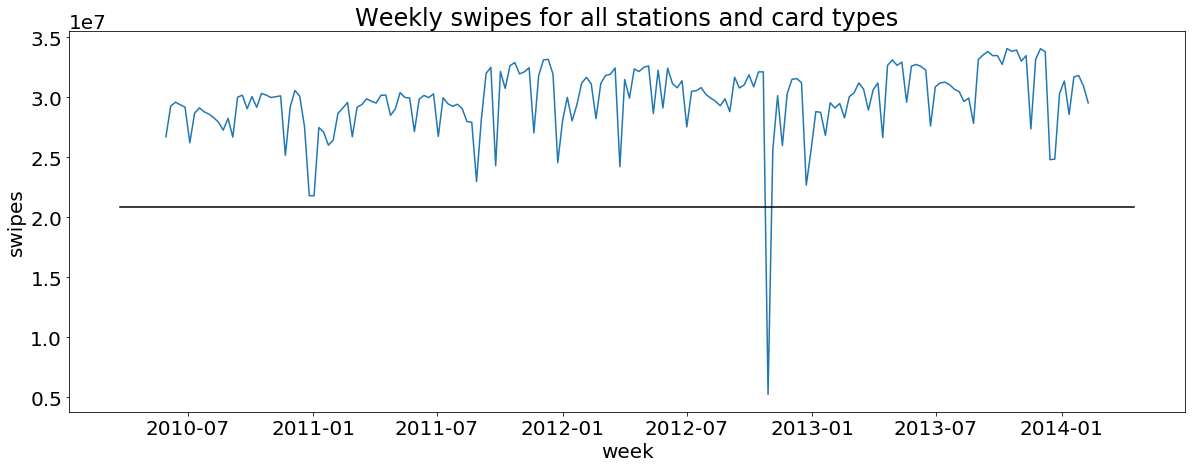

In [12]:
#Plot timeseries with the threshold
fig, ax1 = pl.subplots(1,1, figsize=(20,7))

ax1.plot(date_range, mta_total_week, '-')
ax1.plot([ax1.get_xlim()[0], ax1.get_xlim()[1]], [thresholds[1], thresholds[1]], color='k')

ax1.set_title('Weekly swipes for all stations and card types')
ax1.set_xlabel('week')
ax1.set_ylabel('swipes')

pl.show()

**Figure 2: Total weekly swipes showing the event.** The horizontal line represents a 3 sigma threshold to identify significant drops in the weekly number of swipes. We can see there is one such event on the last weeks of October 2012.

In [13]:
#Get event date
event = date_range[mta_total_week < thresholds[1]]
print('The event was on the week of {}'.format(str(event[0].date())))

The event was on the week of 2012-10-28


This is the week when Hurricane Sandy hit New York City, the reason why there was a significant drop in the number of rides

 # 2: Finding trends

## NOTE ON THE TREND DETECTION:
### Find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

In [14]:
#Collapse data into card types, suming across stations
mta_by_type = np.nansum(mta, axis=0)
mta_by_type.shape

(23, 194)

In [15]:
#Calculate rolling mean with pandas (need to traspose or it does it across stations instead of time)
mta_by_type_smooth = pd.rolling_mean(mta_by_type.T, 5, min_periods=1, center=True)
mta_by_type_smooth = mta_by_type_smooth.T

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  from ipykernel import kernelapp as app


In [42]:
#Calculate initial and final ridership (mean of the first/last 3 weeks)
initial_mean = np.nanmean(mta_by_type_smooth[:,:3],axis=1)
final_mean = np.nanmean(mta_by_type_smooth[:,:-3],axis=1)

#Calculate the ratio
ratio = (final_mean - initial_mean)/initial_mean

#Get the min and max ratio to identify the steepest changes
ranked_trend = np.argsort(-ratio)

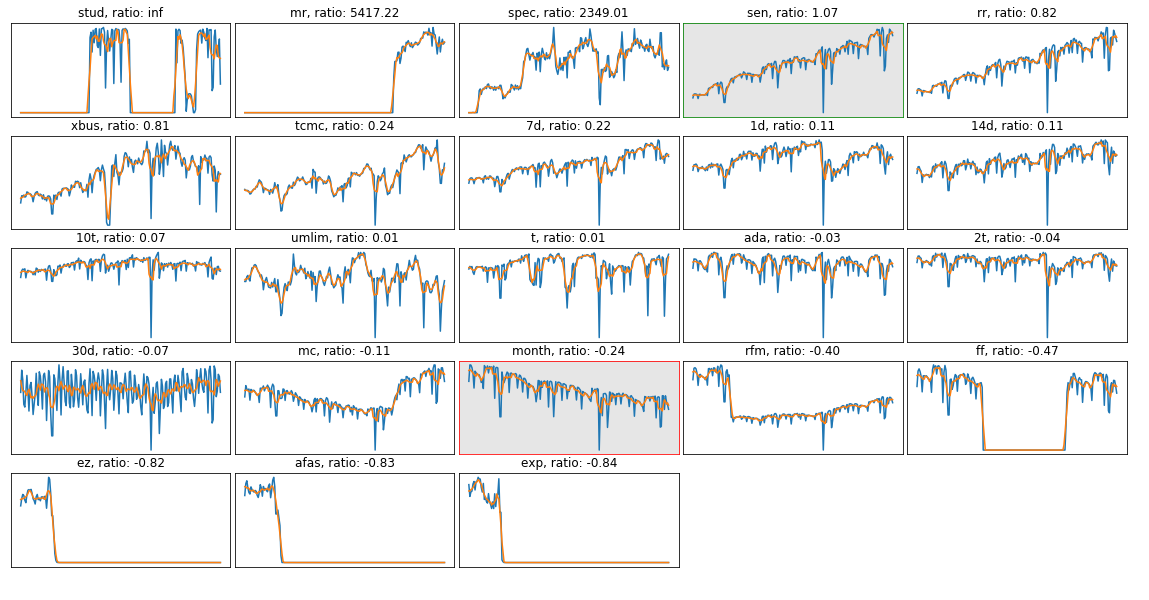

In [43]:
#Plot one to see if it is ok
fig, axes = pl.subplots(5,5, figsize=(20,10))
fig.subplots_adjust(hspace=0.2)
fig.subplots_adjust(wspace=0.02)

#Plot by steepness
for i in range(len(ranked_trend)):
    
    col = i//5
    row = i-col*5
    
    ax = axes[col][row]
    
    #timeseries and smoothed
    ax.plot(date_range, mta_by_type[ranked_trend[i]], '-')
    ax.plot(date_range, mta_by_type_smooth[ranked_trend[i]], '-')
    ax.set_xticks([])
    ax.set_yticks([])
    
    #title
    ax.set_title('{}, ratio: {:.2f}'.format(ridetype[ranked_trend[i]], ratio[ranked_trend[i]]), fontsize=12)

#remove last two
axes[4,3].axis('off')
axes[4,4].axis('off')

#Highlight the highest and lowest
axes[0,3].set_facecolor('0.9')
for s in axes[0,3].spines.values():
    s.set_color('green')

axes[3,2].set_facecolor('0.9')
for s in axes[3,2].spines.values():
    s.set_color('red')

pl.show()

**Figure 3: Card type weekly swipes ordered by steepness.** The figure shows all the time series for each card type, ordered from the steepest increase to the steepest decrease. We can see that there are some time series with big changes in structure; the ones that are highlighted are the card types with a constant trend with the steepest increase (seniors citizen/disabled) and with a steepest decrease (monthly pass) 

# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [62]:
#Reshape the cube to have all timeseries
mta_flat = mta.reshape((mta.shape[0]*mta.shape[1], mta.shape[2]))
mta_flat.shape

(13800, 194)

In [63]:
#Generate the labels
label = np.array([l for l in range(len(ridetype))]*600)
label.shape

(13800,)

In [64]:
#Create a mask to drop all timeseries that have nans
mta_is_nan = np.isnan(mta)
mta_is_nan = np.any(mta_is_nan, axis=2).flatten()
mta_is_nan.shape

(13800,)

In [65]:
#Create a mask to drop time series that are only zeroes
mta_all_zeroes = np.array([np.count_nonzero(serie) == 0 for serie in mta_flat])
mta_all_zeroes.shape

(13800,)

In [66]:
#Total to drop
mta_all_zeroes.sum(), mta_is_nan.sum()

(1514, 4626)

In [67]:
#Drop timeseries
mta_flat = mta_flat[~mta_is_nan & ~mta_all_zeroes]
mta_flat.shape

(7660, 194)

In [68]:
#Drop labels
label = label[~mta_is_nan & ~mta_all_zeroes]
label.shape

(7660,)

In [69]:
label[:26]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       18,  0,  1,  2,  3,  4,  5,  6,  7])

In [70]:
#Calculate mean for each station
stationsmeans = np.nanmean(np.nansum(mta, axis=1), axis=1)
stationsmeans.shape

(600,)

In [71]:
#Calculate std for each station
stationsstd = np.nanstd(np.nansum(mta, axis=1), axis=1)
stationsstd.shape

(600,)

In [72]:
#Creat a station_id index, and use the same mask
station_id = np.concatenate([np.array([i] * 23) for i in range(600)])
station_id = station_id[~mta_is_nan & ~mta_all_zeroes]
station_id.shape

(7660,)

In [73]:
#calculate the normed mean and std for each time series
normed_time_series_mean = np.zeros_like(station_id).astype(float)
normed_time_series_std = np.zeros_like(station_id).astype(float)

for i in range(len(mta_flat)):
    normed_time_series_mean[i] = np.mean(mta_flat[i])/stationsmeans[station_id[i]]
    normed_time_series_std[i] = np.std(mta_flat[i])/stationsstd[station_id[i]]

In [74]:
normed_time_series_mean[:10]

array([  4.89901897e-01,   1.99592561e-02,   2.47622856e-03,
         4.17685680e-03,   3.99896681e-04,   2.38353365e-01,
         1.73759377e-01,   5.33669949e-05,   6.38980818e-04,
         4.14981752e-03])

In [75]:
normed_time_series_std[:10]

array([ 0.39959997,  0.04451416,  0.00830758,  0.01001533,  0.00432403,
        0.29220479,  0.18617148,  0.00125256,  0.01134925,  0.06855351])

In [76]:
#Standardize the data
standardizedts = np.zeros_like(mta_flat).astype(float)

for i in range(len(mta_flat)):
    standardizedts[i] = (mta_flat[i] - np.mean(mta_flat[i]))/np.std(mta_flat[i])

Text(0,0.5,'standardized number of rides')

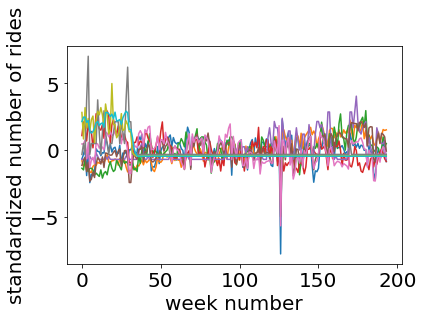

In [77]:
for i in range(10):
    pl.plot(standardizedts[i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")

In [78]:
#Fit a line to each standardized line
allfits = []

for i in range(len(standardizedts)):
    allfits.append(sm.OLS(standardizedts[i], sm.add_constant(np.array(range(len(standardizedts[i]))))).fit())

[a.params[1] for a in allfits[:5]]

[9.7580952041542224e-05,
 0.01507491129603278,
 0.011078420496296554,
 -0.011058851565539807,
 0.010604996938815645]

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [79]:
#Split tran and test
#*No shuffle param in this version of train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              normed_time_series_mean, normed_time_series_std]).T, 
    label, test_size=0.33, random_state=42)

In [80]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((5132, 4), (2528, 4), (5132,), (2528,))

In [81]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(0, 0, 0, 0)

In [82]:
#Fit Random Forest Classifier
clf = rfc(random_state=20)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=20, verbose=0, warm_start=False)

In [83]:
#Predict
y_pred = clf.predict(X_test)

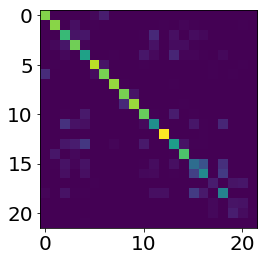

In [479]:
#Confusion matrix
imshow(confusion_matrix(y_test, y_pred))

**Confusion matix:** We can see that most of the time series in the confusion matrix are in the diagonal, so they are classified correctly.

In [480]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.86      0.89      0.87       135
        14d       0.90      0.91      0.90       133
         1d       0.61      0.67      0.64       148
         2t       0.75      0.78      0.77       147
        30d       0.56      0.68      0.61       124
         7d       0.93      0.92      0.92       144
        ada       0.85      0.82      0.84       142
       afas       0.98      0.98      0.98       126
        exp       0.87      0.94      0.90       125
         ez       0.94      0.87      0.91       143
         ff       0.80      0.82      0.81       137
         mc       0.62      0.53      0.57       138
         mr       0.95      0.99      0.97       149
      month       0.64      0.55      0.59       146
        rfm       0.86      0.89      0.88       119
         rr       0.42      0.38      0.40       138
        sen       0.56      0.49      0.52       142
       spec       0.58      0.38      0.46   

In [481]:
clf.feature_importances_

array([ 0.18707563,  0.20477999,  0.34800923,  0.26013515])

**Classification report:** We can see that we got a high precision score on average, at 0.74. However, the score for each of the cardtypes varies a lot, ranging from 0.22 to 0.98. It makes sense that the card types with less time series to train the model from (after the cleaning process) are the ones that have a lower score.

**Feature importances:** We can see that the most relevant feature is the slope of the line fit.

## Build a model that uses as input features each time stamp (194 features) :


In [482]:
# use the same split ratio
X_train, X_test, y_train, y_test = train_test_split(mta_flat, label, test_size=0.33, random_state=42)

In [483]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((5132, 194), (2528, 194), (5132,), (2528,))

In [484]:
clf = rfc(random_state = 20)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=20, verbose=0, warm_start=False)

In [485]:
y_pred = clf.predict(X_test)

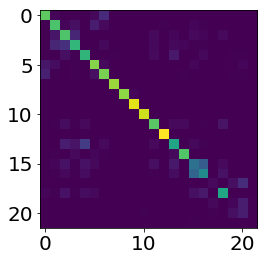

In [486]:
imshow(confusion_matrix(y_test, y_pred))

In [487]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.82      0.82      0.82       135
        14d       0.73      0.80      0.76       133
         1d       0.63      0.72      0.68       148
         2t       0.70      0.67      0.68       147
        30d       0.67      0.78      0.72       124
         7d       0.81      0.84      0.83       144
        ada       0.78      0.83      0.80       142
       afas       0.99      1.00      1.00       126
        exp       0.99      0.98      0.99       125
         ez       0.99      0.99      0.99       143
         ff       0.99      1.00      1.00       137
         mc       0.83      0.80      0.81       138
         mr       0.99      0.99      0.99       149
      month       0.70      0.60      0.64       146
        rfm       0.93      0.91      0.92       119
         rr       0.45      0.40      0.42       138
        sen       0.53      0.50      0.52       142
       spec       0.50      0.14      0.22   

**Comments:** It is interesting that this model using the data as is, without feature engineering, gets a higher score that the previous one. This makes sense because we lost some information when reducing the features, but the reduction is small considering that we went from 194 features to only 4.